**PROBLEM STATEMENT**

**Objective:**
To categorise the countries using socio-economic and health factors that determine the overall development of the country.

**About organization:**
HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities.

**Problem Statement:**
HELP International have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. So, CEO has to make decision to choose the countries that are in the direst need of aid. Hence, your Job as a Data scientist is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.


**Solution:**
We will use the concept of clustering in unsupervised learning and we will try to find out the group of countries which needs the fund most and also give detailed analysis report. We will also create an application for the NGO where they need to enter the details (Socio-economic data) and it will predict what cluster does that data belong to. 

**DATA DECTIONARY**

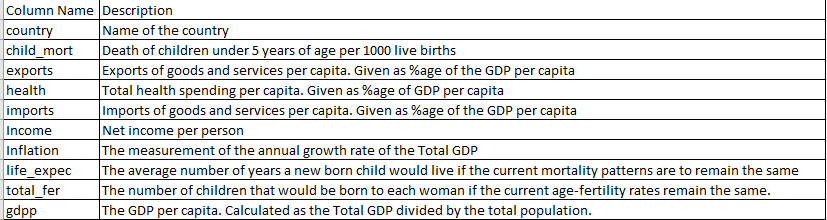

In [179]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import kmeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer,KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import pickle

ImportError: cannot import name 'kmeans' from 'sklearn.cluster' (C:\Users\Mr Siddharth Sangwan\anaconda3\Lib\site-packages\sklearn\cluster\__init__.py)

In [ ]:
# loading dataset
data=pd.read_csv('Country-data.csv')

In [ ]:
data.head()

In [ ]:
data.set_index('country',inplace=True)

In [ ]:
data.head()

In [ ]:
data.shape    # no. of rows and columns

In [ ]:
data.info()

In [ ]:
# 5 point summary of data
data.describe()

In [ ]:
# lets look at the correlation heatmap to identify any significant relations
sns.heatmap(data.corr(),annot=True,vmin=-1,cmap='RdBu',mask=np.triu(data.corr(),k=1))

**Inferences**

* Countries with highter life expectency have significantly lower child mortality
* People living in countries with higher GDP/population have higher incomes
* People with better income have low child morality rate
*  

## Visualization

In [ ]:
sns.pairplot(data,diag_kind='kde')
plt.show()

In [ ]:
# Lets explore the skeweness and outliers using boxplot

t=1
plt.figure(figsize=(12,8))
for i in data:
    plt.subplot(3,3,t)
    sns.boxplot(data,x=i)
    plt.title(f'Skeweness:{round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

## Preprocessing

In [ ]:
## Checking missing values

data.isnull().sum()

In [ ]:
# checking duplicates
data.duplicated().sum()

In [ ]:
# Lets treat the outliers   (Capping)

for i in data:
    q1,q3=data[i].quantile([.25,.75])
    iqr=q3-q1
    ll=q1-1.5*iqr
    ul=q3+1.5*iqr
    data[i]=data[i].apply(lambda x:ll if x<ll else ul if x>ul else x)

In [ ]:
# checking if we have capped all the outliers or not

t=1
plt.figure(figsize=(12,8))
for i in data:
    plt.subplot(3,3,t)
    sns.boxplot(data,x=i)
    plt.title(f'Skeweness:{round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

In [ ]:
# Scaling the data

scaler=StandardScaler()
data_s=pd.DataFrame(scaler.fit_transform(data),columns=data.columns)

In [ ]:
data_s.head()

## Reducing the data using PCA

In [ ]:
pca=PCA(n_components=9)
pca.fit(data_s)

In [ ]:
# lets see how many PC's we can have
pca.explained_variance_

# So as per Kaiser Criterion we can have 3 PC's

In [180]:
pca.explained_variance_ratio_

array([0.48892383, 0.16452848, 0.13756787, 0.09504553, 0.0650032 ,
       0.02011842, 0.01655859, 0.00899467, 0.00325941])

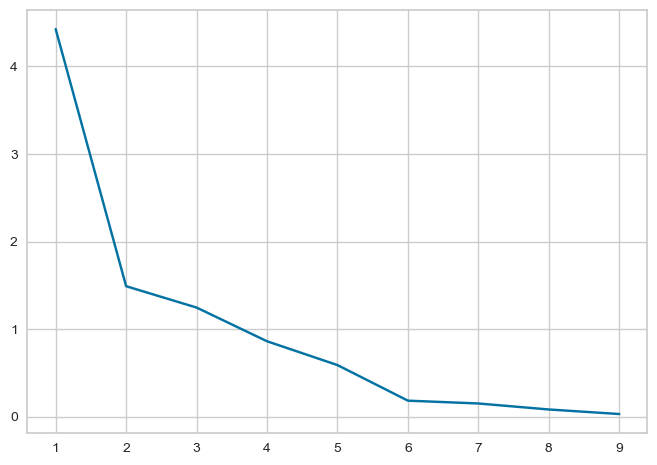

In [181]:
# Lets see a scree plot

plt.plot(range(1,10),pca.explained_variance_)
plt.show()

In [182]:
# lets check from explained variance percentage
# lets use PC's that explain 90% variance

pca.explained_variance_ratio_.cumsum()

array([0.48892383, 0.65345231, 0.79102018, 0.88606572, 0.95106892,
       0.97118734, 0.98774592, 0.99674059, 1.        ])

*So lets go with 5 PC's that are explaining 95% of variation in the data 

In [183]:
pca_final=PCA(n_components=5)
pca_data=pd.DataFrame(pca_final.fit_transform(data_s),columns=range(1,6))

In [184]:
pca_data

,1,2,3,4,5
0,-3.177917,-0.251292,-1.011474,0.778804,-0.014102
1,0.434979,-0.218700,-0.292591,-1.391241,0.156711
2,-0.416784,-0.613870,1.637859,-0.615021,0.536604
3,-3.306409,1.066649,2.151219,1.698677,0.160551
4,1.253246,0.547778,-0.136955,-0.716890,-0.394628
...,...,...,...,...,...
162,-0.882087,0.945856,-0.227550,-0.680105,-0.551247
163,-0.240053,-1.742315,2.238331,-0.080500,1.318475
164,0.305579,2.152785,0.455745,-0.746171,1.383759
165,-2.271105,-0.554296,1.524967,0.313639,1.295477


## K-Means Clustering

In [185]:
# Lets decide the value of K

In [187]:
kelbow=KElbowVisualizer(estimator=KMeans(),k=10)

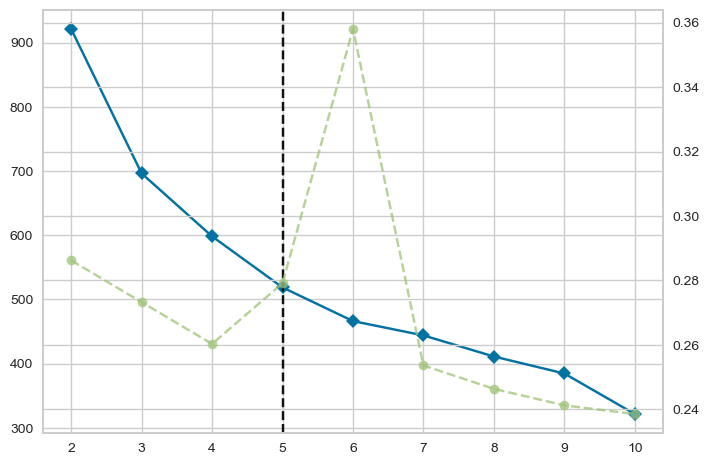

In [188]:
kelbow.fit(pca_data)
plt.show()

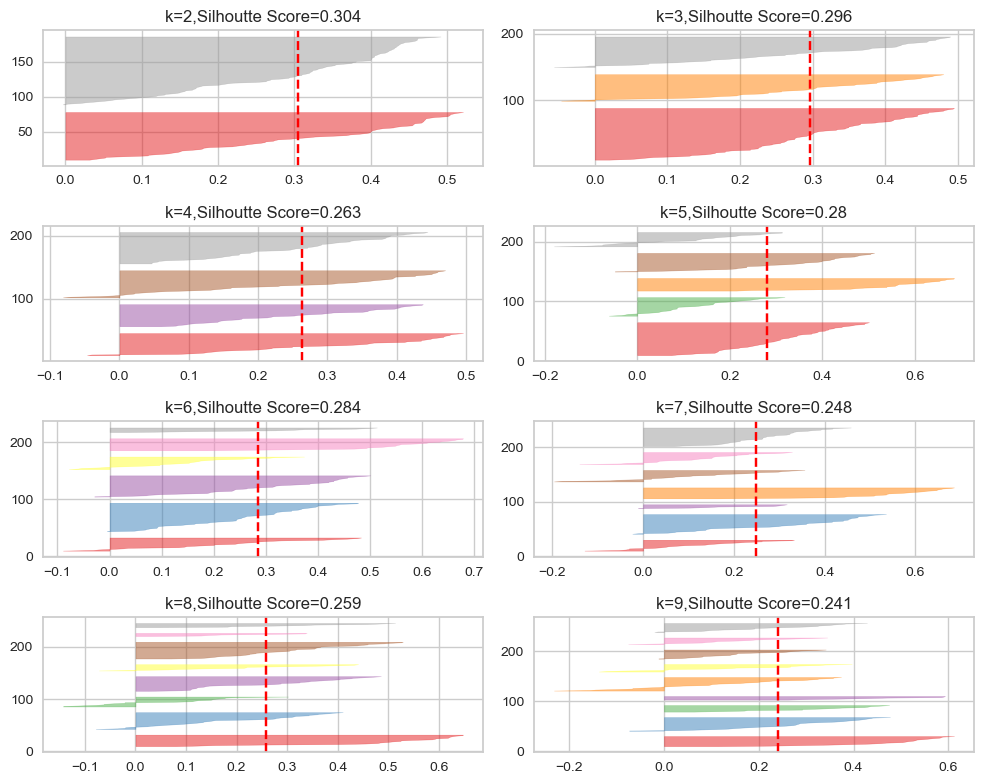

In [193]:
# Silhouette Visualizer

t=1
plt.figure(figsize=(10,8))
for i in range(2,10):
    plt.subplot(4,2,t)
    model=KMeans(n_clusters=i)
    sil_viz=SilhouetteVisualizer(estimator=model)
    sil_viz.fit(pca_data)
    plt.title(f'k={i},Silhoutte Score={round(sil_viz.silhouette_score_,3)}')
    t+=1
plt.tight_layout()
plt.show()

In [194]:
kmeans=KMeans(n_clusters=3,random_state=0)

In [195]:
pred=kmeans.fit_predict(pca_data)

In [196]:
pred

array([2, 1, 1, 2, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1,
       1, 0, 1, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 0, 0,
       0, 1, 1, 1, 1, 2, 2, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 1, 1, 2, 2, 1,
       2, 0, 0, 1, 1, 1, 2, 0, 0, 0, 1, 0, 1, 1, 2, 2, 0, 1, 2, 1, 1, 2,
       2, 1, 1, 0, 1, 2, 2, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1,
       0, 0, 2, 2, 0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 2, 1, 1,
       2, 0, 0, 0, 1, 2, 0, 0, 1, 1, 2, 1, 0, 0, 1, 2, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2])

In [197]:
data['Label']=pred

In [198]:
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Label
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,2
Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,1
Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460.0,1
Angola,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530.0,2
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200.0,1


In [199]:
data['Label'].value_counts()

Label
1    79
2    47
0    41
Name: count, dtype: int64

In [200]:
# lets see the clusters as well

centroids=kmeans.cluster_centers_
centroids

array([[ 2.76085927e+00, -2.57703282e-01, -1.80319664e-03,
         7.56488039e-01, -2.30228038e-01],
       [ 1.15165708e-01,  1.00083114e-01,  1.17443009e-01,
        -7.63932710e-01,  2.20033144e-01],
       [-2.60198555e+00,  5.65801824e-02, -1.95831206e-01,
         6.24142010e-01, -1.69005720e-01]])

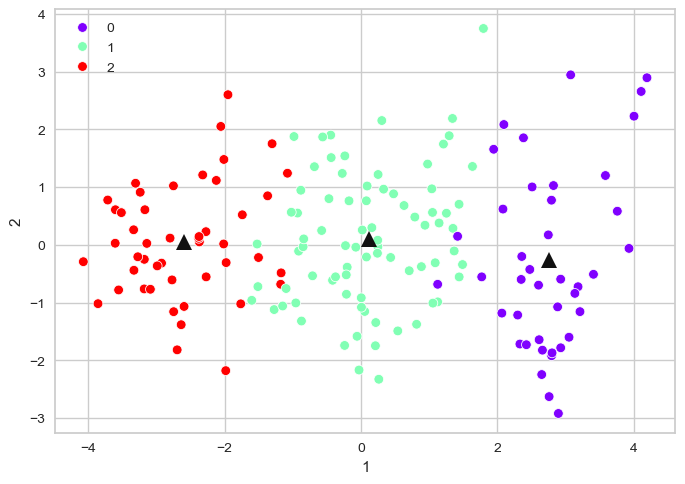

In [201]:
sns.scatterplot(data=pca_data,x=1,y=2,hue=pred,palette='rainbow')
for i in range(3):
    plt.plot(centroids[i][0],centroids[i][1],color='k',marker='^',ms=12)
plt.show()

## Business Interpretations

In [202]:
data.groupby(by='Label').mean().T

Label,0,1,2
child_mort,5.651220,22.510127,91.182979
exports,52.719512,39.438671,28.225936
health,8.331951,6.314177,6.253830
imports,47.598171,47.714873,41.233317
income,38988.780488,11198.101266,3738.574468
inflation,3.235171,7.178468,10.215426
life_expec,79.514634,72.546835,59.777660
total_fer,1.799756,2.324177,4.987819
gdpp,28969.512195,5771.189873,1808.297872


In [203]:
data['Label']=data['Label'].map({0:'Developed',1:'Developing',2:'Underdeveloped'})

In [204]:
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Label
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,Underdeveloped
Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,Developing
Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460.0,Developing
Angola,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530.0,Underdeveloped
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200.0,Developing


In [205]:
data[data['Label']=='Underdeveloped'].index.to_list()

['Afghanistan',
 'Angola',
 'Benin',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Equatorial Guinea',
 'Eritrea',
 'Gabon',
 'Gambia',
 'Ghana',
 'Guinea',
 'Guinea-Bissau',
 'Haiti',
 'Iraq',
 'Kenya',
 'Kiribati',
 'Lao',
 'Lesotho',
 'Liberia',
 'Madagascar',
 'Malawi',
 'Mali',
 'Mauritania',
 'Mozambique',
 'Myanmar',
 'Namibia',
 'Niger',
 'Nigeria',
 'Pakistan',
 'Rwanda',
 'Senegal',
 'Sierra Leone',
 'South Africa',
 'Sudan',
 'Tanzania',
 'Timor-Leste',
 'Togo',
 'Uganda',
 'Yemen',
 'Zambia']

In [206]:
data[data['Label']=='Developed'].index.to_list()

['Australia',
 'Austria',
 'Bahamas',
 'Bahrain',
 'Belgium',
 'Brunei',
 'Canada',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Iceland',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Kuwait',
 'Luxembourg',
 'Malta',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Oman',
 'Portugal',
 'Qatar',
 'Saudi Arabia',
 'Singapore',
 'Slovak Republic',
 'Slovenia',
 'South Korea',
 'Spain',
 'Sweden',
 'Switzerland',
 'United Arab Emirates',
 'United Kingdom',
 'United States']

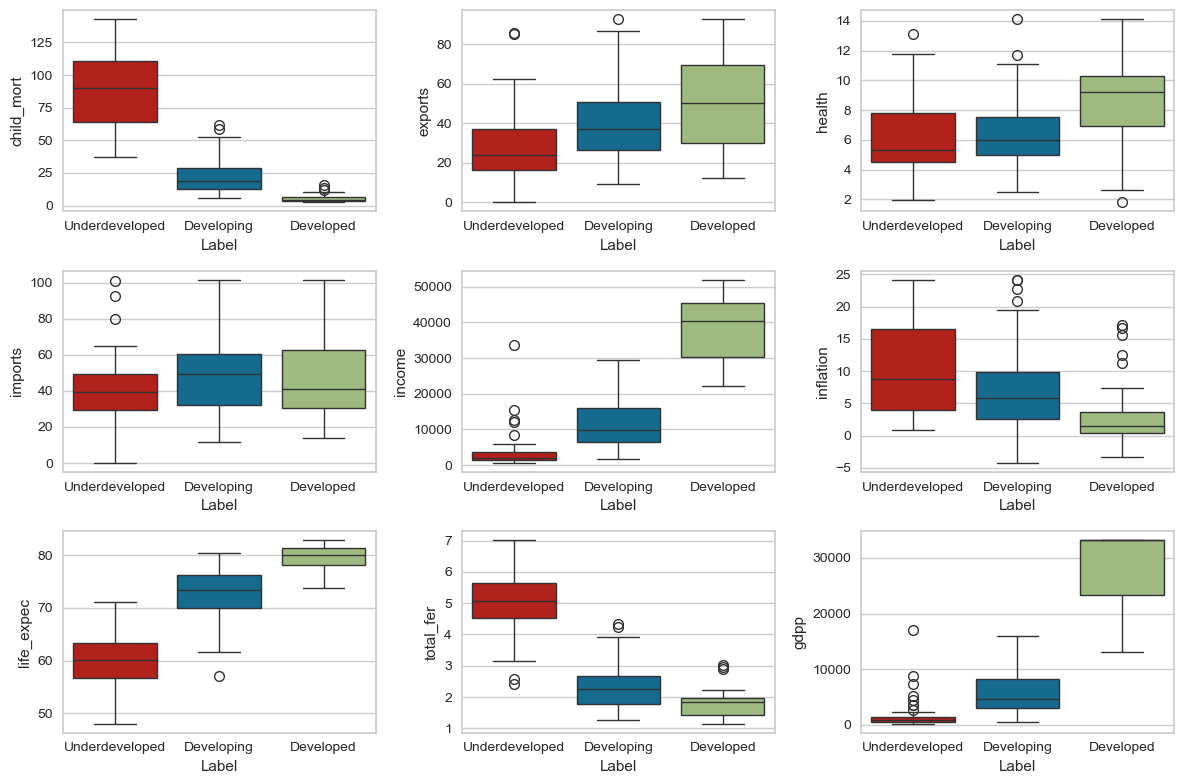

In [207]:
# Lets visualize the clusters
t=1
plt.figure(figsize=(12,8))
for i in data:
    if i != 'Label':
        plt.subplot(3,3,t)
        sns.boxplot(data,y=i,x='Label',palette=['r','b','g'])
        t+=1
plt.tight_layout()
plt.show()

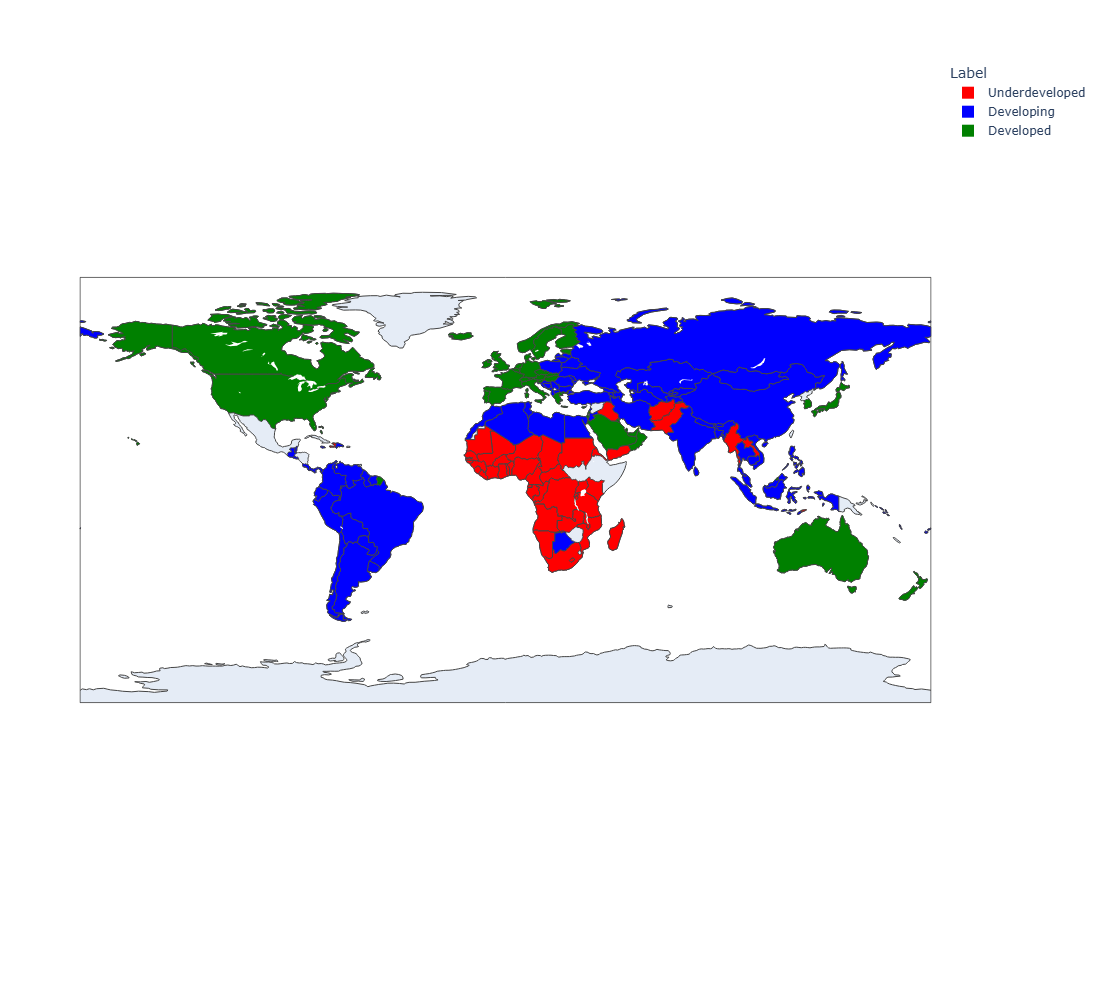

In [208]:
# lets represent this on World Map

px.choropleth(data_frame=data,locationmode='country names',locations=data.index,color='Label',color_discrete_map={'Developed':'green','Developing':'blue','Underdeveloped':'red'}, width=1000,
    height=1000)

## Deployment

In [209]:
# in order to make predictions

In [210]:
pca_data.head()

,1,2,3,4,5
0,-3.177917,-0.251292,-1.011474,0.778804,-0.014102
1,0.434979,-0.218700,-0.292591,-1.391241,0.156711
2,-0.416784,-0.613870,1.637859,-0.615021,0.536604
3,-3.306409,1.066649,2.151219,1.698677,0.160551
4,1.253246,0.547778,-0.136955,-0.716890,-0.394628


In [211]:
kmeans.predict([[-3.177917,-0.251292,-1.011474,0.778804,-0.014102]])

array([2])

In [212]:
# lets download the instances that we require to deploy
with open('scaler,pkl','wb') as file:
    pickle.dump(scaler,file)

with open('pca.pkl','wb') as file:
    pickle.dump(pca_final,file)

with open('model.pkl','wb') as file:
    pickle.dump(kmeans,file)